<a href="https://colab.research.google.com/github/GoldPapaya/info256-applied-nlp/blob/main/5.classification/HW5_FeatureExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dbamman/anlp25/blob/main/5.classification/HW5_FeatureExploration.ipynb)

**N.B.** Once it's open on Colab, remember to save a copy (by e.g. clicking `Copy to Drive` above).

---

# Feature engineering for text classification

This notebook explores feature engineering for text classification.  Your task is to create two new feature functions (like `dictionary_feature` and `unigram_feature` below), and include them in the `build_features` function.  What features do you think will help for your particular problem? Your grade is *not* tied to whether accuracy goes up or down, so be creative!  You are free to read in any other external resources you like (dictionaries, document metadata, etc.)

You are free to use any of the following datasets for this exercise, or to use your own (if you have your own labeled data with at least 500 examples from at least two classes, I would encourage you to use it!).  If you use your own data, just be sure to format it like the examples below; each directory has a `train.tsv`, `dev.tsv` and `test.tsv` file, where each file is tab-separated (label in the first column and text in the second column).

* [Sentiment Analysis](https://ai.stanford.edu/~amaas/data/sentiment/) (Positive/Negative)
* [Congressional Speech](https://www.cs.cornell.edu/home/llee/data/convote.html) (Democrat/Republican)
* Library of Congress Subject Classication ([21 categories](https://en.wikipedia.org/wiki/Library_of_Congress_Classification))

For whichever dataset you pick, download the data first using the code below.


In [ ]:
# get LMRD data
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/lmrd/train.tsv -O lmrd_train.tsv
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/lmrd/dev.tsv -O lmrd_dev.tsv
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/lmrd/test.tsv -O lmrd_test.tsv

In [1]:
# get Convote data
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/convote/train.tsv -O convote_train.tsv
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/convote/dev.tsv -O convote_dev.tsv
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/convote/test.tsv -O convote_test.tsv

--2025-09-26 17:45:48--  https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/convote/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4660140 (4.4M) [text/plain]
Saving to: ‘convote_train.tsv’

convote_train.tsv   100%[===================>]   4.44M  --.-KB/s    in 0.05s   

2025-09-26 17:45:49 (86.8 MB/s) - ‘convote_train.tsv’ saved [4660140/4660140]

--2025-09-26 17:45:49--  https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/convote/dev.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [ ]:
# get LoC data
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/loc/train.tsv -O loc_train.tsv
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/loc/dev.tsv -O loc_dev.tsv
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/loc/test.tsv -O loc_test.tsv

In [2]:
import operator
import sys
from collections import Counter

import nltk
from nltk import word_tokenize
from sklearn import linear_model, preprocessing

nltk.download("punkt")
nltk.download("punkt_tab")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Part 1: Loading data

**Q1: Briefly describe your data (including the categories you're predicting).**  If you're using your own data, tell us about it; if you're using one of the datasets above, tell us something that shows you've looked at the data. How many examples are in each category?

In [3]:
def read_data(filename):
    df = pd.read_csv(filename, names=["label", "text"], sep="\t")
    return df.text.to_list(), df.label.to_list()

In [4]:
# Change this to the directory with the data you will be using.
# The directory should contain train.tsv, dev.tsv and test.tsv
data = "convote"

x_train, y_train = read_data("%s_train.tsv" % data)
x_dev, y_dev = read_data("%s_dev.tsv" % data)

In [5]:
from collections import Counter

print(x_train[0])
print(y_train[0] + "\n")
print(x_dev[0])
print(y_dev[0] + "\n")
print("Train: ", Counter(y_train))
print("Dev: ", Counter(y_dev))

mr. speaker , i rise in opposition to the rules package that we have before us today .  it is outrageous that my republican colleagues have placed before us a rules package that at best lacks integrity , and at worst is completely unethical .  as the highest body of elected officials in our country , we should be held to the highest ethical standards .  but instead , my republican colleagues have opted to put before us a rules package that actually lowers our ethics standards , so that they may promote their own agenda , at whatever cost .  this rules package makes it far more difficult for ethics investigations to take place .  by requiring a majority of the ethics committee before an investigation can even begin , we are in great danger of diminishing the integrity of our great institution .  with this new rule , the majority party can effectively block any ethics investigation of a member of their party .  this is an abuse of power .  and it 's not just democrats who oppose this pla

These data are of congressional debate speeches, containing a label ("R" or "D") and a speech (transcribed to text), seperated by tab. There are 1373 passages labelled R and 1350 passages labelled D in the training data, and 130 passages labelled R and 127 labelled D in the dev data, as shown above.

## Part 2: Features

Here, you will hand-engineer some features for your classifier.

In [6]:
## HELPER FUNCTIONS ##

def majority_class(y_train, y_dev):
    label_counts = Counter(y_train)
    majority = label_counts.most_common(1)[0][0]

    correct = 0.
    for label in y_dev:
        if label == majority:
            correct += 1

    print("%s\t%.3f" % (majority, correct/len(y_dev)))
    return correct / len(y_dev)

def build_features(x_train, feature_functions):
    data = []
    for doc in x_train:
        feats = {}
        tokens = doc.split(" ")

        for function in feature_functions:
            feats.update(function(tokens))

        data.append(feats)
    return data

# This helper function converts a dictionary of feature names to unique numerical ids
def create_vocab(data):
    feature_vocab = {}
    idx = 0
    for doc in data:
        for feat in doc:
            if feat not in feature_vocab:
                feature_vocab[feat] = idx
                idx += 1

    return feature_vocab

# This helper function converts a dictionary of feature names to a sparse representation
# that we can fit in a scikit-learn model.  This is important because almost all feature
# values will be 0 for most documents (note: why?), and we don't want to save them all in
# memory.

def features_to_ids(data, feature_vocab):
    new_data = sparse.lil_matrix((len(data), len(feature_vocab)))
    for idx,doc in enumerate(data):
        for f in doc:
            if f in feature_vocab:
                new_data[idx, feature_vocab[f]] = doc[f]
    return new_data

We'll start with two feature classes -- one feature class noting the presence of a word in an external dictionary, and one feature class for the word identity (i.e., unigram).  We'll implement each feature class as a function that takes a single document as input (as a list of tokens) and returns a dict corresponding to the feature we're creating.

In [7]:
# Here's a sample dictionary we can create by inspecting the output of the Mann-Whitney test (in 2.compare/)

# EDIT TO FIT YOUR DATASET (this already sort of fits the convote data, so I
# just added to it)
dem_dictionary = set(["republican","cut", "opposition", "programs", "spending"])
repub_dictionary = set(["growth","economy", "budget", "business"])

def political_dictionary_feature(tokens):
    feats = {}
    for word in tokens:
        if word in dem_dictionary:
            feats["word_in_dem_dictionary"] = 1
        if word in repub_dictionary:
            feats["word_in_repub_dictionary"] = 1
    return feats

In [8]:
def unigram_feature(tokens):
    feats = {}
    for word in tokens:
        feats["UNIGRAM_%s" % word] = 1
    return feats

**Q2**: **Add first new feature function here.**  Describe your feature and why you think it will help.

In [9]:
# finds word combinations like "tax_cut" or "illegal_aliens"
def bigram_feature(tokens):
    feats={}
    for i in range(len(tokens)-1):
      feats["BIGRAM_%s" % tokens[i] + "_" + tokens[i+1]] = 1
    return feats

This is a bigram feature. It does essentially the same thing as the unigram feature but will be especially helpful for identifying pairs of co-occuring words.

**Q3**: **Add second new feature function here.** Describe your feature and why you think it will help.

In [10]:
def document_length_feature(tokens):
    feats={}
    feats["document_length"] = len(tokens)
    return feats

D or R speech length could be different and therefore it may help to have a feature for it.

We use the `build_features` helper function to aggregate together all of the information from different feature classes.  Each document has a feature dict (`feats`), and we'll update that dict with the new dict that each separate feature class is returning.  (Here you want to make sure that the keys each feature function is creating are unique so they don't get clobbered by other functions).

In [19]:
# This function trains a model and returns the predicted and true labels for test data
def evaluate(x_train, x_dev, y_train, y_dev, feature_functions):
    x_train_feat = build_features(x_train, feature_functions)
    x_dev_feat = build_features(x_dev, feature_functions)

    # just create vocabulary from features in *training* data
    feature_vocab = create_vocab(x_train_feat)

    x_train_ids = features_to_ids(x_train_feat, feature_vocab)
    x_dev_ids = features_to_ids(x_dev_feat, feature_vocab)

    logreg = linear_model.LogisticRegression(C=1.0, solver='lbfgs', penalty='l2', max_iter=10000)
    logreg.fit(x_train_ids, y_train)
    predictions = logreg.predict(x_dev_ids)
    return (predictions, y_dev)
    return logreg, feature_vocab, predictions, y_dev

In [13]:
def print_weights(clf, vocab, n=10):
    reverse_vocab = [None]*len(clf.coef_[0])
    for k in vocab:
        reverse_vocab[vocab[k]] = k

    if len(clf.classes_) == 2:

        weights=clf.coef_[0]
        for feature, weight in sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))[:n]:
            print("%.3f\t%s" % (weight, feature))

        print()

        for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
            print("%.3f\t%s" % (weight, feature))

    else:
        for i, cat in enumerate(clf.classes_):

            weights=clf.coef_[i]

            for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                print("%s\t%.3f\t%s" % (cat, weight, feature))
            print()

In [14]:
majority_class(y_train,y_dev)

R	0.506


0.5058365758754864

Explore the impact of different feature functions by evaluating them below:

In [17]:
# this does the same thing as evaluate() but returns a vocab and classifier.
# I need these params for print_weights().
# This function trains a model and returns the predicted and true labels for test data
def pipeline(x_train, x_dev, y_train, y_dev, feature_functions):
    x_train_feat = build_features(x_train, feature_functions)
    x_dev_feat = build_features(x_dev, feature_functions)

    # just create vocabulary from features in *training* data
    feature_vocab = create_vocab(x_train_feat)

    x_train_ids = features_to_ids(x_train_feat, feature_vocab)
    x_dev_ids = features_to_ids(x_dev_feat, feature_vocab)

    logreg = linear_model.LogisticRegression(C=1.0, solver='lbfgs', penalty='l2', max_iter=10000)
    logreg.fit(x_train_ids, y_train)
    predictions = logreg.predict(x_dev_ids)
    return logreg, feature_vocab

In [26]:
features = [bigram_feature]
clf, vocab = pipeline(x_train, x_dev, y_train, y_dev, features)

If you want to print the coefficients for any of the models you train, you can do so like this.

In [27]:
print_weights(clf, vocab)

-0.814	BIGRAM_the_republican
-0.757	BIGRAM_the_majority
-0.717	BIGRAM_am_,
-0.714	BIGRAM_yes_,
-0.714	BIGRAM_objection_.
-0.703	BIGRAM_gentleman_.
-0.684	BIGRAM_mr._speaker
-0.678	BIGRAM_,_reclaiming
-0.677	BIGRAM_mr._leader
-0.675	BIGRAM_parliamentary_inquiry

1.090	BIGRAM_chairman_.
0.838	BIGRAM_the_motion
0.834	BIGRAM_yielding_.
0.790	BIGRAM_the_gentlewoman
0.651	BIGRAM_to_claim
0.646	BIGRAM_i_reserve
0.619	BIGRAM_the_resolution
0.606	BIGRAM_look_forward
0.579	BIGRAM_,_mr.
0.578	BIGRAM_my_point


## Part 3: Analysis

**Q4**: Implement a function that returns the parametric confidence interval bounds for a binomial estimator of the model accuracy. It should return a tuple of floats `(lower_bound, upper_bound)`.

In [28]:
def binomial_test(predictions, targets, significance_level=0.95):
    n = len(targets)
    correct = np.sum(np.array(predictions) == np.array(targets))
    p = correct / n

    # handles common alpha values 0.05 and 0.01
    if significance_level == 0.95:
        z = 1.96
    elif significance_level == 0.99:
        z = 2.58

    se = np.sqrt(p*(1 - p)/n)

    lower_bound = max(0.0, p - z * se)
    upper_bound = min(1.0, p + z * se)

    return (lower_bound, upper_bound)

**Q5**: Plot the performance for models trained with different combinations of features, including your two custom features. Some combinations you might try (but feel free to pick your own!):
1. Just the dictionary features
2. Just the unigram features
3. Just your custom features
4. Unigram features + custom features

Make a bar plot with confidence intervals. Does incorporating your features result in a statistically significant change in performance?

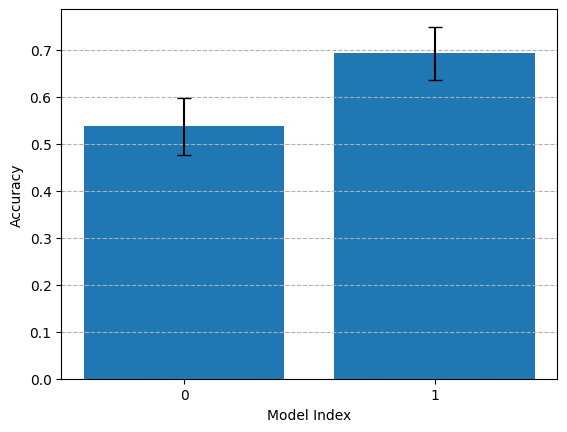

In [51]:
# example of how to train a classifier with the dictionary and unigram features
#features = [political_dictionary_feature, unigram_feature]
#predictions, targets = evaluate(x_train, x_dev, y_train, y_dev, features)
#lower_bound, upper_bound = binomial_test(predictions, targets)

import matplotlib.pyplot as plt

features = [
    [political_dictionary_feature], # 0
    [unigram_feature], # 1
    [bigram_feature, document_length_feature], # 2
    [unigram_feature, bigram_feature, document_length_feature], # 3
    [political_dictionary_feature, unigram_feature], # 4
    [political_dictionary_feature, unigram_feature, bigram_feature, document_length_feature] # 5
    ]
feature_index = 0
results = {}

# evaluate models with features
for feats in features:
    predictions, targets = evaluate(x_train, x_dev, y_train, y_dev, feats)  # last two outputs are preds & targets
    accuracy = sum(predictions == targets) / len(targets)
    lower_bound, upper_bound = binomial_test(predictions, targets)
    results[str(feature_index)] = (accuracy, lower_bound, upper_bound)
    feature_index += 1

labels = list(results.keys()) # x axis will show index number of corresponding model from features list

accuracies = [results[i][0] for i in labels] # y axis will show accuracy of each model

errors_lower = [results[i][0] - results[i][1] for i in labels] # plot lower bound, accuracy - lower
errors_upper = [results[i][2] - results[i][0] for i in labels] # plot upper bound, upper - accuracy

plt.bar(labels, accuracies, yerr=[errors_lower, errors_upper], capsize=5)
plt.ylabel("Accuracy")
plt.xlabel("Model Index")
plt.grid(axis='y', linestyle='--')
plt.show()


---

## To submit

Congratulations on finishing this homework!
Please follow the instructions below to download the notebook file (`.ipynb`) and its printed version (`.pdf`) for submission on bCourses -- remember **all cells must be executed**.

1.  Download a copy of the notebook file: `File > Download > Download .ipynb`.

2.  Print the notebook as PDF (via your browser, or tools like [nbconvert](https://nbconvert.readthedocs.io/en/latest/)).